In [1]:
%load_ext autoreload
%autoreload 2
import os
from Utils.Utils import stitch_bpod_times, select_DIO_channel, find_min_distance_TTL, extract_time, extract_analogIO, check_single_rec_file, extract_DIO, check_timestamp_gaps, get_mouse_name,get_recording_day, find_mat_files_with_same_day, check_gpu_availability
from pathlib import Path
import numpy as np
from spikeinterface.extractors import read_spikegadgets
import spikeinterface.full as si
from spikeinterface.preprocessing import detect_bad_channels
from Utils.Settings import channel_label_color_dict
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import panel as pn

pn.extension(design="bootstrap", sizing_mode="fixed",throttled=True)

# Ott lab spikesorting single session
#####  Multi-Neuropixels recording using SpikeGadgets

## Select file

In [2]:
# folder containing .rec file
path_recording_folder = Path("/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/")


In [3]:
mouse_n = get_mouse_name(path_recording_folder)
day = get_recording_day(path_recording_folder)

In [4]:
day

'20231212'

In [5]:
path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

Exactly one .rec file found: 20231212_183552.rec


In [6]:
raw_rec = read_spikegadgets(path_recording)
fs = raw_rec.get_sampling_frequency()

In [7]:
f"Recording duration in minutes: {raw_rec.get_total_duration()/60}, sampling rate: {fs} Hz"

'Recording duration in minutes: 154.06692055555555, sampling rate: 30000.0 Hz'

In [8]:
f"Probes present: {raw_rec.get_probes()}"

'Probes present: [Probe - 384ch - 1shanks, Probe - 384ch - 1shanks]'

## Pre-processing

### Highpass filter

In [190]:
rec_filt = si.highpass_filter(raw_rec, freq_min=300.)

### Detect bad channels

In [191]:
# detect noisy, dead, and out-of-brain channels
bad_channel_ids, channel_labels = detect_bad_channels(high_passed_rec, dead_channel_threshold=-1)

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/preprocessing/detect_bad_channels.py:333: RuntimeWarning: invalid value encountered in divide
  xcorr = np.sum(raw * ref[:, np.newaxis], axis=0) / np.sum(ref**2)


In [ ]:
count = np.unique(channel_labels, return_counts=True)
if (count[0].shape[0] == 1) & (count[0][0]=="good"):
     print("no bad channels")
else:
    for n in range(count[0].shape[0]):
        print(f"{count[1][n]} {count[0][n]} channels")
    rec_filt = rec_filt.remove_channels(bad_channel_ids)
    print("bad channels removed")

### Inspect probes

In [295]:
y_lim_widget = pn.widgets.EditableRangeSlider(
    name='y_lim', start=0, end=raw_rec.get_channel_locations().max(), value=(raw_rec.get_channel_locations().max()-800, raw_rec.get_channel_locations().max()-200),
    step=10)

channels_colors = [channel_label_color_dict[label] for label in channel_labels]

@pn.depends(y_lim_widget)
def inspect_probes_channels_labels(ylim):
    fig, axs = plt.subplots(1,3, figsize=(10, 6))

    si.plot_probe_map(raw_rec, color_channels=channels_colors, ax=axs[0], with_channel_ids=False)
      
    si.plot_probe_map(raw_rec, color_channels=channels_colors, ax=axs[1], with_channel_ids=False)
    
    patches = [mpatches.Patch(color=color, label=label) for label, color in channel_label_color_dict.items()]
    
    axs[2].legend(handles=patches, loc='upper left', frameon=False );
    axs[2].axis("off");
    #axs[0].
    
    axs[1].set_ylim(ylim[0], ylim[1] )
    
    # Draw a rectangle on axs[0] with these ylims
    # Assuming arbitrary x values, here 0 to 10 for illustration
    rect = mpatches.Rectangle((-100, ylim[0]), 600, ylim[1] - ylim[0], linewidth=1, edgecolor='r', facecolor='none')
    
    axs[0].add_patch(rect)
    plt.close()
    return pn.pane.Matplotlib(fig)

Column(design=<class 'panel.theme.bootst...)
    [0] EditableRangeSlider(design=<class 'panel.theme.bootst..., end=3920.0, name='y_lim', step=10, value=(3120.0, 3720.0), width=300)
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False, design=<class 'panel.theme.bootst...)
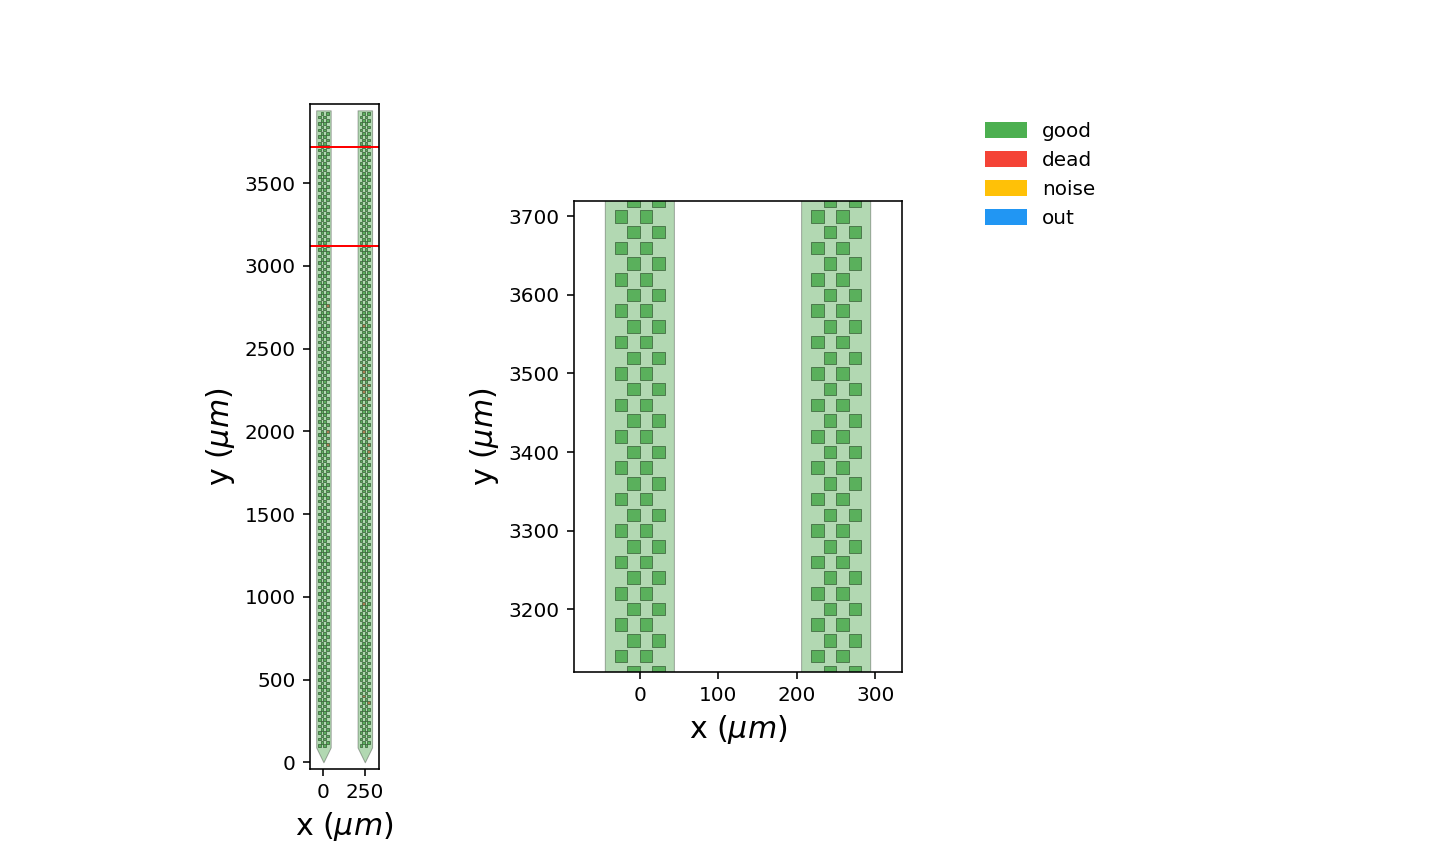

In [296]:
pn.Column(y_lim_widget, inspect_probes_channels_labels)

## Sorting

In [102]:
%%time

check_gpu_availability()

split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items():
    sorting = si.run_sorter(
        sorter_name="kilosort4",
        recording=sub_rec,
        output_folder=f"{path_recording_folder}/spike_interface_output/probe{group}",
        verbose=True,
        remove_existing_folder=True
        )

GPU available: n = 1
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  7.38s; total  7.38s

computing drift
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:36<00:00,  1.03it/s]


drift computed in  527.25s; total  534.63s

Extracting spikes using templates
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:34<00:00,  1.03it/s]


2660633 spikes extracted in  523.71s; total  1058.35s

First clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [08:53<00:00,  5.56s/it]


315 clusters found, in  534.55s; total  1592.90s

Extracting spikes using cluster waveforms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [04:26<00:00,  1.99it/s]


3295389 spikes extracted in  267.40s; total  1860.30s

Final clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [07:54<00:00,  4.94s/it]


277 clusters found, in  474.07s; total  2334.36s

Merging clusters
274 units found, in  2.39s; total  2336.76s

Saving to phy and computing refractory periods
50 units found with good refractory periods

Total runtime: 2368.57s = 00:39:29 h:m:s
kilosort4 run time 2373.54s
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  7.40s; total  7.40s

computing drift
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:33<00:00,  1.03it/s]


drift computed in  525.22s; total  532.61s

Extracting spikes using templates
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:31<00:00,  1.04it/s]


2663568 spikes extracted in  520.47s; total  1053.08s

First clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [09:10<00:00,  5.73s/it]


280 clusters found, in  550.92s; total  1604.01s

Extracting spikes using cluster waveforms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [04:16<00:00,  2.07it/s]


2707623 spikes extracted in  256.53s; total  1860.53s

Final clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [05:32<00:00,  3.46s/it]


269 clusters found, in  332.19s; total  2192.72s

Merging clusters
265 units found, in  1.66s; total  2194.38s

Saving to phy and computing refractory periods
41 units found with good refractory periods

Total runtime: 2223.44s = 00:37:3 h:m:s
kilosort4 run time 2226.19s
CPU times: user 17h 14min 18s, sys: 30min 51s, total: 17h 45min 10s
Wall time: 1h 16min 45s


## Post-processing

In [315]:
times = sorting.get_times()

In [316]:
times[sorting.get_unit_spike_train(unit_id=0)]

array([1.43600000e-01, 1.91000000e-01, 2.46000000e-01, ...,
       9.45401367e+02, 9.45416233e+02, 9.45479733e+02])

In [271]:
sorting = si.read_sorter_folder(f"{path_recording_folder}/spike_interface_output/probe{group}")

In [273]:
analyzer = si.create_sorting_analyzer(sorting, recording, sparse=True, format="memory")

estimate_sparsity:   0%|          | 0/1059 [00:00<?, ?it/s]

In [291]:
job_kwargs = dict(chunk_duration='10s', progress_bar=True, n_jobs=20)

In [293]:
%%time
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
analyzer.compute("waveforms",  ms_before=1.5,ms_after=2., **job_kwargs)

compute_waveforms:   0%|          | 0/106 [00:00<?, ?it/s]

In [299]:
%%time
analyzer.compute("templates", operators=["average", "median", "std"])
analyzer.compute("noise_levels")

CPU times: user 17.5 s, sys: 1.89 s, total: 19.4 s
Wall time: 19.4 s


In [300]:
metric_names=['firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']

metrics = si.compute_quality_metrics(analyzer, metric_names=metric_names)

metrics

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:880: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


,amplitude_cutoff,firing_rate,isi_violations_ratio,isi_violations_count,presence_ratio,snr
0,0.003159,8.357617,0.108184,24.0,0.941176,1.378960
1,0.001450,13.576405,0.169115,99.0,0.941176,1.610459
2,0.009316,5.407703,0.344541,32.0,0.941176,1.318156
3,0.010244,14.413301,0.247045,163.0,0.941176,3.397470
4,0.000518,21.547691,0.888354,1310.0,0.941176,2.220658
...,...,...,...,...,...,...
269,NaN,0.062342,0.000000,0.0,0.647059,10.361514
270,0.003171,11.898837,0.582651,262.0,0.941176,4.977450
271,0.006390,20.979055,0.393466,550.0,0.941176,7.330107
272,0.001046,9.330532,0.549727,152.0,0.941176,4.409061


In [ ]:
%%time
from tqdm.notebook import tqdm
spike_times = {}
for unit_id in tqdm(sorting.unit_ids):
    spike_times[unit_id] = times[sorting.get_unit_spike_train(unit_id=0)]

In [809]:
gaps = check_timestamp_gaps(raw_rec)

No gaps detected.


## Alignment between Bpod and Trodes

### Export Analog IO channels

In [9]:
%%time
extract_analogIO(path_recording_folder, path_recording)# 55 min too slow


'.analog' folder alread available: 20231212_183552.analog
CPU times: user 531 µs, sys: 34 µs, total: 565 µs
Wall time: 629 µs


### Export timestamps

In [10]:
%%time
#extract_time(path_recording_folder, path_recording) # slower than analogIO somehow!!

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


### Export Digital IO channels

In [11]:
%%time
#check if already available, if not extract
extract_DIO(path_recording_folder, path_recording) # TODO what is timestampoffset?

'.DIO' folder alread available: 20231212_183552.DIO
CPU times: user 508 µs, sys: 34 µs, total: 542 µs
Wall time: 499 µs


In [12]:
path_DIO_folder = Path(path_recording_folder,  f"{rec_file_name[:rec_file_name.rfind('.')]}.DIO")

DIO_dict = select_DIO_channel(path_DIO_folder)

20231212_183552.dio_Controller_Din1.dat contains data
1 DIO files with data


/alzheimer/Roberto/Github/spikesorting/Utils/TrodesToPython/readTrodesExtractedDataFile3.py:114: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [13]:
# Each data point is (timestamp, state) -> break into separate arrays
DIO_data = DIO_dict['data']
DIO_states = np.array([tup[1] for tup in DIO_data])
DIO_samples = np.array([tup[0] for tup in DIO_data])
DIO_timestamps = np.array([tup[0] for tup in DIO_data])/float(DIO_dict['clockrate'])
assert DIO_states.shape == DIO_timestamps.shape

DIO_timestamps_1 = DIO_timestamps[DIO_states.astype(bool)]
DIO_samples_1_zeroed = (DIO_samples[DIO_states.astype(bool)]-DIO_samples[DIO_states.astype(bool)][0]).astype("int32")
DIO_samples_1 = DIO_samples[DIO_states.astype(bool)]
DIO_timestamps_1_zeroed = (DIO_timestamps[DIO_states.astype(bool)]-DIO_timestamps[DIO_states.astype(bool)][0])

## load bpod mat file behavior

In [14]:
bpod_file = find_mat_files_with_same_day(path_recording_folder.parent.parent / "bpod_session" , day)

.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231212_181618/12_AuditoryTuning_20231212_181618.mat
.mat file found: /alzheimer/Roberto/Dariya/12/bpod_session/20231212_185101/12_DetectionConfidence_20231212_185101.mat


In [15]:
trials =  stitch_bpod_times(bpod_file, day, DIO_timestamps_1_zeroed)

/alzheimer/Roberto/Dariya/12/bpod_session/20231212_181618/12_AuditoryTuning_20231212_181618.mat
Bpod session started at 18:36:24, duration: 12.826175000000001 min, ended at: 18:49:13
/alzheimer/Roberto/Dariya/12/bpod_session/20231212_185101/12_DetectionConfidence_20231212_185101.mat
Bpod session started at 18:51:30, duration: 137.31311333333332 min, ended at: 21:08:48


In [16]:
start_times_bpod = trials["bpod_start_time"]

In [17]:
start_samples_bpod = (trials["bpod_start_time"]*fs).values
start_samples_bpod_zeroed = (start_times_bpod -start_times_bpod[0]).astype("int32")

The most distant pulse in array1 is at index 1399 with time 273636776
This pulse has a minimum distance of 273627680.0 to the closest pulse in array2


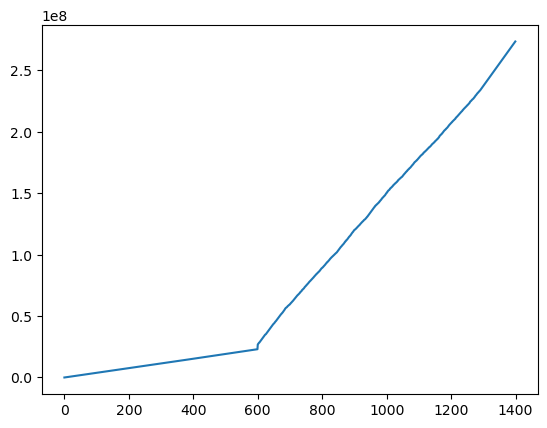

In [18]:
min_distances = find_min_distance_TTL(DIO_samples_1_zeroed, start_samples_bpod_zeroed)

In [19]:
if len(trials)!=len(DIO_timestamps[DIO_states.astype(bool)]):
    print("unequal numbers of trials between bpod and DIO")
    if np.argmax(min_distances) == len(start_samples_bpod_zeroed):
        print("One extra TTL pulse received on DIO at the end of the session")
        DIO_samples_1_zeroed = DIO_samples_1_zeroed[:-1]
        DIO_samples_1 = DIO_samples_1[:-1]
        DIO_timestamps_1 = DIO_timestamps_1[:-1]
        print("extra TTL pulse removed")

unequal numbers of trials between bpod and DIO
One extra TTL pulse received on DIO at the end of the session
extra TTL pulse removed


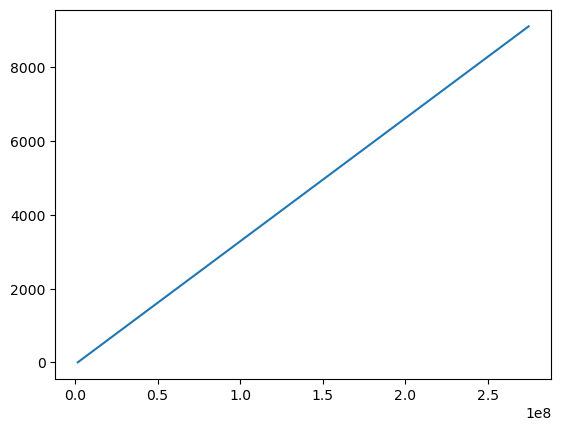

In [20]:
plt.plot(DIO_samples_1, start_samples_bpod_zeroed)

In [21]:
trials["DIO_start_sample"] = DIO_samples_1
trials["DIO_start_time"] = DIO_timestamps_1
trials

,bpod_start_time,bpod_stop_time,stimulus_block,stimulus_name,DIO_start_sample,DIO_start_time
0,1.1802,2.3802,0,BpodProtocols_AuditoryTuning.git,1591690,53.056333
1,2.4890,3.6890,0,BpodProtocols_AuditoryTuning.git,1630955,54.365167
2,3.7490,4.9490,0,BpodProtocols_AuditoryTuning.git,1668755,55.625167
3,5.0100,6.2100,0,BpodProtocols_AuditoryTuning.git,1706585,56.886167
4,6.2691,7.4691,0,BpodProtocols_AuditoryTuning.git,1744358,58.145267
...,...,...,...,...,...,...
1394,9061.3978,9062.5978,1,BpodProtocols_DetectionConfidence.git,273400252,9113.341733
1395,9073.5830,9074.7830,1,BpodProtocols_DetectionConfidence.git,273765811,9125.527033
1396,9085.7843,9086.9843,1,BpodProtocols_DetectionConfidence.git,274131853,9137.728433
1397,9097.9691,9099.1691,1,BpodProtocols_DetectionConfidence.git,274497400,9149.913333


## Load Trodes timestamps

In [873]:
path_analogIO_folder = Path(path_recording_folder,  f"{rec_file_name[:rec_file_name.rfind('.')]}.analog")

In [882]:
analog_dict = readTrodesExtractedDataFile(Path(path_analogIO_folder, f"{rec_file_name[:rec_file_name.rfind('.')]}.timestamps.dat"))

In [883]:
analog_dict["data"].shape

(277320457,)

In [884]:
raw_rec.get_total_samples()

277320457